0 tensor(0.7691)
Done


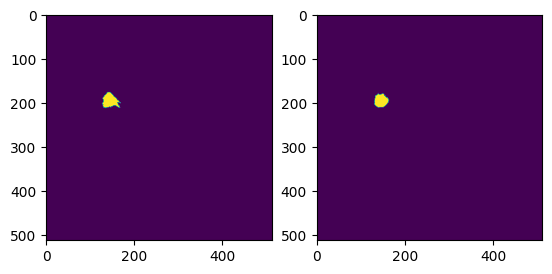

In [ ]:
import numpy as np
import cv2
from isegm.data.datasets import Lidc2dDataset
from albumentations import Compose, Normalize
from torch.utils.data import DataLoader
from isegm.classical_approaches.snake_fill import SnakeMasker
import matplotlib.pyplot as plt
import os

# Define paths
train_image_path = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D/train'
mask_path = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D/train/slice_annotations/'
output_prediction_path = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D/train/initial_masks/active_contours'

# Define transformations
transformations = Compose([Normalize(mean=0, std=1)])

# Initialize datasets and data loaders
dataset = Lidc2dDataset(train_image_path, transform=transformations)
train_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Specific parameter for SnakeMasker
circle_size_param = 8  # or any other value you'd like to set
masker = SnakeMasker(circle_size=circle_size_param)

def get_iou(gt_mask, pred_mask, ignore_label=-1):
    ignore_gt_mask_inv = gt_mask != ignore_label
    obj_gt_mask = gt_mask == 1

    intersection = np.logical_and(
        np.logical_and(pred_mask, obj_gt_mask), ignore_gt_mask_inv
    ).sum()
    union = np.logical_and(
        np.logical_or(pred_mask, obj_gt_mask), ignore_gt_mask_inv
    ).sum()

    return intersection / union

def save_predictions_to_path(loader, masker, output_path):
    # filenames = sorted([f for f in os.listdir(mask_path) if os.path.isfile(os.path.join(mask_path, f))])
    for i, (image, gt_mask) in enumerate(loader):
        image = image.squeeze().numpy()
        
        # Use the filename from the mask directory
        # filename = os.path.splitext(filenames[i])[0] + '.npy'
        # save_path = os.path.join(output_path, filename)
        
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(gt_mask[0,:,:].numpy().astype(np.uint8))
        coordinates = [(int(centroids[label][1]), int(centroids[label][0])) for label in range(1, num_labels)]
        predicted_mask = masker.predict(image, coordinates)
        # fig, ax = plt.subplots(1, 2)
        # ax[0].imshow(gt_mask[0, :, :])
        # ax[1].imshow(predicted_mask)
        
        print(i, get_iou(gt_mask[0, :, :], predicted_mask))
        
        if i == 0:
            break
        
        # Convert the predicted mask to boolean array and save as .npy
        # bool_mask = predicted_mask.astype(bool)
        # np.save(save_path, bool_mask)

# Save predictions to path for the training set
save_predictions_to_path(train_loader, masker, output_prediction_path)
print('Done')


In [ ]:
print(f'Starting:')

    # Define paths
    base_path = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D'
    datasets = ['train']

    # Define transformations for normalization
    transformations = Compose([Normalize(mean=0, std=1)])

    # Specific parameter for SnakeMasker
    circle_size_param = 8
    masker = SnakeMasker(circle_size=circle_size_param)

    for dataset in datasets:
        print(f"Processing {dataset} dataset...")
        dataset_path = os.path.join(base_path, dataset)
        output_path = os.path.join(
            base_path, dataset, 'initial_masks', 'active_contours'
        )

        transformations = Compose([Normalize(mean=0, std=1)])
        dataset = Lidc2dDataset(data_dir=dataset_path, transform=transformations)

        train_loader = DataLoader(dataset, batch_size=1, shuffle=False)

        for i, (image, gt_mask) in enumerate(train_loader):
            gt_mask = gt_mask.squeeze().numpy()
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
                gt_mask.astype(np.uint8)
            )
            coords = [
                (int(centroids[label][1]), int(centroids[label][0]))
                for label in range(1, num_labels)
            ]
            labels = masker.predict(image.squeeze().numpy(), coords)
            
            print(i, get_iou(gt_mask, labels))

            # file_path = os.path.join(output_path, dataset.file_names[i])
            # np.save(file_path, labels.astype(bool))
            # print(f'Saved file {i}: {file_path}')

    print('Done')